<a href="https://colab.research.google.com/github/yunnsss/-Persona-Development-and-Marketing-Strategy-/blob/main/RFM_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install openpyxl

In [ ]:
import pandas as pd
import numpy as np

from datetime import datetime

import seaborn as sns
import matplotlib.font_manager as fm
import datetime as dt

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import math

# options library
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False
pd.set_option('display.max_columns',None)
pd.set_option('display.max_row',None)

In [ ]:
# 데이터 불러오기
apps = pd.read_csv('/kaggle/input/dive2024-origin/dive_apps_log.csv')
#cust = pd.read_csv('/kaggle/input/dive2024-origin/dive_cust_info.csv')
#final_cluster_3K = pd.read_csv('/kaggle/input/bnk-cluster/final_cluster_3K.csv')

### 컬럼명 변경하기

In [ ]:
apps.columns = ['기준일자', '기준시간', '이벤트명', '이벤트타입', '이벤트ID', '클릭버튼', '순번']
cust.columns =  ['연령', '성별', '주소지', '자산잔액', '부채잔액', '카드사용액', '순번']

In [ ]:
cust['카드사용액'].unique()

array(['4. 십만 원 이상 ~ 이십만 원 미만', '6. 삼십만 원 이상 ~ 오십만 원 미만', '0. 카드 미사용',
       '5. 이십만 원 이상 ~ 삼십만 원 미만', '2. 일만 원 이상 ~ 오만 원 미만',
       '8. 일백만 원 이상 ~ 이백만 원 미만', '7. 오십만 원 이상 ~ 일백만 원 미만',
       '3. 오만 원 이상 ~ 십만 원 미만', '9. 이백만 원 이상', '1. 일만 원 미만'], dtype=object)

In [ ]:
cust['카드사용액'].value_counts()

카드사용액
0. 카드 미사용                 279845
7. 오십만 원 이상 ~ 일백만 원 미만     91090
6. 삼십만 원 이상 ~ 오십만 원 미만     82767
4. 십만 원 이상 ~ 이십만 원 미만      80082
2. 일만 원 이상 ~ 오만 원 미만       62225
5. 이십만 원 이상 ~ 삼십만 원 미만     59758
3. 오만 원 이상 ~ 십만 원 미만       57479
8. 일백만 원 이상 ~ 이백만 원 미만     50299
1. 일만 원 미만                 37246
9. 이백만 원 이상                13411
Name: count, dtype: int64

### 1~2초 사이에 발생한 중복 데이터 제거

In [ ]:
# DataFrame 복사
apps_copy = apps.copy()
df_cleaned = apps.copy()

# 기준시간을 datetime 형식으로 변환
df_cleaned['기준시간'] = pd.to_datetime(df_cleaned['기준시간'], format='%H:%M:%S')

# '기준시간'을 제외한 나머지 열이 중복되는 행 찾기
duplicated_mask = df_cleaned.duplicated(subset=df_cleaned.columns.difference(['기준시간']), keep=False)

# 중복된 행들만 추출
duplicates = df_cleaned[duplicated_mask]

# 중복된 행 중에서 '기준시간' 차이가 1~2초인 그룹을 찾아 제거
# 각 그룹별로 기준시간 차이를 계산하여 차이가 1~2초 사이인 경우 하나만 남기기
def drop_near_duplicates(group):
    group = group.sort_values(by='기준시간')
    time_diff = group['기준시간'].diff().dt.total_seconds().fillna(0)
    # 시간 차이가 2초 초과하는 행만 남기고 첫 번째 행 유지
    return pd.concat([group[time_diff > 2], group.iloc[[0]]])

# 중복된 그룹을 기준으로 필터링 후 하나의 행만 남김
cleaned_duplicates = duplicates.groupby(df_cleaned.columns.difference(['기준시간']).tolist(), group_keys=False).apply(drop_near_duplicates)

# 중복되지 않은 원본 데이터와 결합
non_duplicates = df_cleaned[~duplicated_mask]
apps_temp = pd.concat([non_duplicates, cleaned_duplicates]).sort_index()

# 최종 apps 데이터에 원본 데이터의 '기준시간'으로 다시 설정
apps_temp['기준시간'] = apps_copy['기준시간']

In [ ]:
# 인덱스 2301과 5547인 행을 출력
specific_rows = apps.loc[[2301, 5547]]

# 결과 출력
print(specific_rows)

      col1      col2             col3     col4     col5 col6    col7
2301     1  11:04:53  af_service_view  inquiry  inquiry  NaN  582660
5547     1  10:58:11  af_service_view  inquiry  inquiry  NaN  363163


In [ ]:
display(apps_temp.head(5))
display(cust.head(5))

,기준일자,기준시간,이벤트명,이벤트타입,이벤트ID,클릭버튼,순번
2301,1,11:04:53,af_service_view,inquiry,inquiry,NaN,582660
5547,1,10:58:11,af_service_view,inquiry,inquiry,NaN,363163
5700,1,10:57:57,af_finishjoin_popup,marketing,deposit,no_money,812002
6317,1,10:56:51,af_finishjoin_popup,marketing,deposit,moneyplus,812002
6886,1,10:55:43,af_service_view,remit,remit,NaN,509971


,연령,성별,주소지,자산잔액,부채잔액,카드사용액,순번
0,25세 이상 ~ 30세 미만,M,부산 사하구,1. 일만 원 이상 ~ 십만 원 미만,0. 대출 미보유,4. 십만 원 이상 ~ 이십만 원 미만,1
1,25세 이상 ~ 30세 미만,M,부산 사하구,1. 일만 원 이상 ~ 십만 원 미만,0. 대출 미보유,6. 삼십만 원 이상 ~ 오십만 원 미만,2
2,25세 이상 ~ 30세 미만,M,부산 북구,0. 일만 원 미만,0. 대출 미보유,4. 십만 원 이상 ~ 이십만 원 미만,3
3,25세 이상 ~ 30세 미만,M,부산 해운대구,1. 일만 원 이상 ~ 십만 원 미만,0. 대출 미보유,0. 카드 미사용,4
4,25세 이상 ~ 30세 미만,M,부산 금정구,7. 오백만 원 이상 ~ 일천만 원 미만,0. 대출 미보유,6. 삼십만 원 이상 ~ 오십만 원 미만,5


In [ ]:
apps_temp.shape

(6974985, 7)

# 전처리

### R: 마지막으로 구매한 시점이 얼마나 최근인지

-  기준일자와 기준시간 차이 수치 적용

#### 다른방법 R 구하는 방법

In [ ]:
apps = apps_temp.copy()

In [ ]:
df2 = apps.copy()

# 시:분:초를 초 단위로 변환하는 함수 정의
def time_to_seconds(t):
    h, m, s = map(int, t.split(':'))
    return h * 3600 + m * 60 + s

# 모든 시:분:초를 초 단위로 변환
df2['초'] = df2['기준시간'].apply(time_to_seconds)

# 기준일자 60이 가장 최근일자이므로 60일을 기준으로 Recency 계산
# 기준일자 60의 초를 0으로 간주하고 다른 기준일자에 대해 초 단위 Recency 계산
df2['Recency'] = df2['초'] + (60 - df2['기준일자']) * 86400  # 하루는 86400초

# 결과 출력
rfm_r = df2[['순번', 'Recency']]

# '순번'별로 'Recency'의 최소값 추출
rfm_r = df2.groupby('순번')['Recency'].min().reset_index()

In [ ]:
rfm_r.info()
#df2.info()
#apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744357 entries, 0 to 744356
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   순번       744357 non-null  int64
 1   Recency  744357 non-null  int64
dtypes: int64(2)
memory usage: 11.4 MB


### M: 고객이 소비한 총 금액, 자산 잔액, 부채 잔액 범주화

- cust의 col4, 5, 6는 문자 분리 후 다른 범주형 변수로 저장


In [ ]:
cust['자산잔액'] = cust['자산잔액'].str.split('.').str[0]
cust['부채잔액'] = cust['부채잔액'].str.split('.').str[0]
cust['카드사용액'] = cust['카드사용액'].str.split('.').str[0]

In [ ]:
rfm_m = cust[['순번','카드사용액']]

### F: 어떤 시스템을 얼마나 자주 이용했는지

- 이벤트 타입(28) > 이벤트 명(105)


In [ ]:
rfm_f = apps.groupby(['순번', '이벤트타입']).size().unstack(fill_value=0)

In [ ]:
apps_temp['순번'].max()

817523

In [ ]:
rfm_m['순번'].nunique()

814202

### 데이터 병합

In [ ]:
cust_fre = rfm_f.merge(rfm_m, on='순번', how='left')

# '순번'을 기준으로 'apps'와 'cust' 병합 (left join 또는 inner join 선택 가능)
rfm_df = pd.merge(cust_fre, rfm_r[['순번', 'Recency']], on='순번', how='left')

# 결과 확인
display(rfm_df.head(5))

,순번,brand,card,deposit,estate,event,exchange,fit,forex,fund,gift,giftbox,gold,guide,home,inquiry,insurance,irp,join,life,loan,main,management,marketing,mycard,othercard,remit,service,welcomebox,카드사용액,Recency
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,1,0,0,4,0,0,4,26045
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,1,0,0,2,0,0,6,135892
2,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,859489
3,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,6,4194489
4,6,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,567741


In [ ]:
print(rfm_r.shape)
print(rfm_f.shape)
print(rfm_m.shape)

(744357, 2)
(744053, 28)
(814202, 2)


## 병합한 데이터 불러오기

In [ ]:
rfm_data = rfm_df.copy()

# Clustering

### 스케일링

In [ ]:
# 2열부터 29열까지 로그 변환
rfm_data.iloc[:, 1:29] = np.log1p(rfm_data.iloc[:, 1:29])  # 인덱스는 0부터 시작하므로 1:29

# 로그 변환이 적용된 데이터프레임 확인
display(rfm_data.head())

,순번,brand,card,deposit,estate,event,exchange,fit,forex,fund,gift,giftbox,gold,guide,home,inquiry,insurance,irp,join,life,loan,main,management,marketing,mycard,othercard,remit,service,welcomebox,카드사용액,Recency
0,1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.564949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,1.609438,0.0,0.0,4,26045
1,2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.302585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,1.098612,0.0,0.0,6,135892
2,4,0.0,0.0,0.693147,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.000000,0.0,0.0,0,859489
3,5,0.0,0.0,0.000000,0.0,0.0,0.693147,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.000000,0.0,0.0,6,4194489
4,6,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.609438,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0,567741


In [ ]:
rfm_data.shape

(744053, 31)

In [ ]:
# 1:29의 열과 마지막 열 선택
new_df = rfm_data.iloc[:, 1:29].copy()  # 2열부터 29열까지 선택
new_df['Recency'] = rfm_data.iloc[:, -1]

display(new_df.head(10))

,brand,card,deposit,estate,event,exchange,fit,forex,fund,gift,giftbox,gold,guide,home,inquiry,insurance,irp,join,life,loan,main,management,marketing,mycard,othercard,remit,service,welcomebox,Recency
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.564949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,1.609438,0.0,0.0,26045
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.302585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,1.098612,0.0,0.0,135892
2,0.0,0.0,0.693147,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.000000,0.0,0.0,859489
3,0.0,0.0,0.000000,0.0,0.0,0.693147,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.000000,0.0,0.0,4194489
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.609438,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,567741
5,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.098612,0.0,0.0,3415805
6,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.000000,0.0,0.0,915864
7,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,0.0,0.0,1016216
8,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.693147,0.0,0.0,1365662
9,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.693147,0.0,0.0,0.693147,0.0,0.0,1350484


In [ ]:
new_df.shape

(744053, 29)

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_df)

# 표준화된 array를 DataFrame으로 다시 변환
rfm_scaled_df = pd.DataFrame(scaled_data, index=new_df.index, columns=new_df.columns)

display(rfm_scaled_df.head())

,brand,card,deposit,estate,event,exchange,fit,forex,fund,gift,giftbox,gold,guide,home,inquiry,insurance,irp,join,life,loan,main,management,marketing,mycard,othercard,remit,service,welcomebox,Recency
0,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,1.902165,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,0.641225,-0.401427,-0.033841,-0.854311
1,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,1.597663,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,0.072443,-0.401427,-0.033841,-0.767652
2,-0.010369,-0.13996,1.198181,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.196803
3,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,3.278335,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-0.270263,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,2.434192
4,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,30.113353,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.426965


In [ ]:
rfm_scaled_df.shape

(744053, 30)

In [ ]:
# rfm_data의 순번 열(첫 번째 열) 선택
sequence_column = rfm_data.iloc[:, 0]  # 1번 열(인덱스 0)

# 순번 열을 rfm_scaled_df에 추가
rfm_scaled_df['순번'] = sequence_column.values  # 'Sequence'라는 이름으로 추가

# 결과 출력
display(rfm_scaled_df.head(10))

,brand,card,deposit,estate,event,exchange,fit,forex,fund,gift,giftbox,gold,guide,home,inquiry,insurance,irp,join,life,loan,main,management,marketing,mycard,othercard,remit,service,welcomebox,Recency,순번
0,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,1.902165,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,0.641225,-0.401427,-0.033841,-0.854311,1
1,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,1.597663,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,0.072443,-0.401427,-0.033841,-0.767652,2
2,-0.010369,-0.13996,1.198181,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.196803,4
3,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,3.278335,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-0.270263,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,2.434192,5
4,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,30.113353,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.426965,6
5,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,0.072443,-0.401427,-0.033841,1.819885,7
6,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-0.270263,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.772183,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.152329,8
7,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-0.270263,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,-0.379025,-0.401427,-0.033841,-0.073161,9
8,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,0.200323,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,-0.379025,-0.401427,-0.033841,0.202519,10
9,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-0.379025,-0.401427,-0.033841,0.190545,11


In [ ]:
rfm_df.shape

(744053, 31)

In [ ]:
column = rfm_df.iloc[:, [0, 29]]  # 30번째 열 선택
display(column.head(30))

,순번,카드사용액
0,1,4
1,2,6
2,4,0
3,5,6
4,6,0
5,7,0
6,8,5
7,9,0
8,10,2
9,11,6


In [ ]:
rfm_scaled_df.shape

(744053, 30)

In [ ]:
final = rfm_scaled_df.merge(column, on='순번', how='left')

In [ ]:
display(final.head(10))
display(final.shape)

,brand,card,deposit,estate,event,exchange,fit,forex,fund,gift,giftbox,gold,guide,home,inquiry,insurance,irp,join,life,loan,main,management,marketing,mycard,othercard,remit,service,welcomebox,Recency,순번,카드사용액
0,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,1.902165,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,0.641225,-0.401427,-0.033841,-0.854311,1,4
1,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,1.597663,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,0.072443,-0.401427,-0.033841,-0.767652,2,6
2,-0.010369,-0.13996,1.198181,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.196803,4,0
3,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,3.278335,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-0.270263,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,2.434192,5,6
4,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,30.113353,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.426965,6,0
5,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,0.072443,-0.401427,-0.033841,1.819885,7,0
6,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-0.270263,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.772183,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.152329,8,5
7,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-0.270263,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,-0.379025,-0.401427,-0.033841,-0.073161,9,0
8,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,0.200323,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,-0.379025,-0.401427,-0.033841,0.202519,10,2
9,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-0.379025,-0.401427,-0.033841,0.190545,11,6


(744053, 31)

## Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler

# 필요한 열만 선택
df = final[['Recency','brand', 'card',
       'deposit', 'estate', 'event', 'exchange', 'fit', 'forex', 'fund',
       'gift', 'giftbox', 'gold', 'guide', 'home', 'inquiry', 'insurance',
       'irp', 'join', 'life', 'loan', 'main', 'management', 'marketing',
       'mycard', 'othercard', 'remit', 'service', 'welcomebox', '카드사용액']]


In [ ]:
df.shape

(744053, 30)

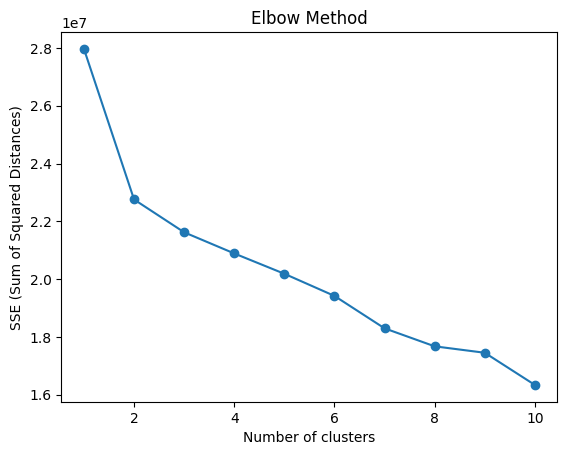

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# The Elbow Method
sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of Squared Distances)')
plt.title('Elbow Method')
plt.show()

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import pandas as pd
# import numpy as np

# # 데이터 스케일링을 이미 수행한 데이터로 가정 (scaled_data 사용)
# # scaled_data = ...

# # 클러스터 개수를 3과 4로 각각 설정한 후 KMeans 실행 및 실루엣 계수 계산
# for k in [3, 4]:
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(df)
#     labels = kmeans.labels_

#     # 실루엣 계수 계산
#     silhouette_avg = silhouette_score(scaled_data, labels)
#     print(f"클러스터 개수 {k}개의 실루엣 계수: {silhouette_avg}")

In [ ]:
# 최적의 클러스터 수로 K-Means 적용
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final['Cluster'] = kmeans.fit_predict(df)

In [ ]:
final.head()

,brand,card,deposit,estate,event,exchange,fit,forex,fund,gift,giftbox,gold,guide,home,inquiry,insurance,irp,join,life,loan,main,management,marketing,mycard,othercard,remit,service,welcomebox,Recency,순번,카드사용액,Cluster
0,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,1.902165,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,0.641225,-0.401427,-0.033841,-0.854311,1,4,1
1,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,1.597663,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,0.072443,-0.401427,-0.033841,-0.767652,2,6,1
2,-0.010369,-0.13996,1.198181,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.196803,4,0,0
3,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,3.278335,-0.012215,-0.0567,-0.039921,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-0.270263,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,0.183811,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,2.434192,5,6,1
4,-0.010369,-0.13996,-0.383266,-0.004878,-0.386203,-0.122596,-0.012215,-0.0567,30.113353,-0.010586,-0.055231,-0.03359,-0.018354,-0.022333,-1.074735,-0.034609,-0.094781,-0.080303,-0.367275,-0.235861,-0.259558,-0.020546,-0.822018,-0.015065,-0.007602,-1.150814,-0.401427,-0.033841,-0.426965,6,0,0


In [ ]:
# final.to_csv('/content/drive/MyDrive/DIVE2024/data/final_cluster_4K.csv', index=False, encoding='utf-8')
final = final_cluster_3K.copy()

In [ ]:
final['Cluster'].value_counts()

Cluster
0    397203
1    346479
2       371
Name: count, dtype: int64

In [ ]:
final.shape

(744053, 32)

## Cluster별로 merge

In [ ]:
# final = final_cluster_3K.copy()

In [ ]:
cluster_0 = final[final['Cluster'] == 0]
cluster_1 = final[final['Cluster'] == 1]
cluster_2 = final[final['Cluster'] == 2]

### cluster 0

In [ ]:
# '기준일자', '카드사용액'을 제외한 새로운 데이터프레임 생성
# cluster_0_dropped = cluster_0.drop(columns=['카드사용액'], errors='ignore')
apps_dropped = apps.drop(columns=['기준일자'], errors='ignore')
cust_dropped = cust.drop(columns=['카드사용액'], errors='ignore')

# '순번'을 기준으로 두 데이터프레임 병합 (inner join)
merged_data = pd.merge(cluster_0, apps_dropped, on='순번', how='inner')

# 그 다음 'cust_dropped'도 '순번'을 기준으로 병합
final_cluster_0 = pd.merge(merged_data, cust_dropped, on='순번', how='inner')

# 결과 확인
print(final_cluster_0.shape)
print(final_cluster_0.head())

(3229079, 42)
      brand     card   deposit    estate     event  exchange       fit  \
0 -0.010369 -0.13996  1.198181 -0.004878 -0.386203 -0.122596 -0.012215   
1 -0.010369 -0.13996  1.198181 -0.004878 -0.386203 -0.122596 -0.012215   
2 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   
3 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   
4 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   

    forex       fund      gift   giftbox     gold     guide      home  \
0 -0.0567  -0.039921 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   
1 -0.0567  -0.039921 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   
2 -0.0567  30.113353 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   
3 -0.0567  30.113353 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   
4 -0.0567  30.113353 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   

    inquiry  insurance       irp      join      life      loan      main  \
0 -1.074735  -0.034609 -0.

In [ ]:
display(final_cluster_0.head())

NameError: name 'final_cluster_0' is not defined

In [ ]:
final_cluster_0.to_csv('final_cluster_0.csv', index=False)

# 캐글에서 파일을 다운로드하려면 아래 명령어를 추가
from IPython.display import FileLink

# 저장한 파일을 다운로드할 수 있는 링크 생성
FileLink('final_cluster_0.csv')

/kaggle/working/final_cluster_0.csv

### cluster 1

In [ ]:
# '기준일자', '카드사용액'을 제외한 새로운 데이터프레임 생성
# cluster_1_dropped = cluster_1.drop(columns=['카드사용액'], errors='ignore')
apps_dropped = apps.drop(columns=['기준일자'], errors='ignore')
cust_dropped = cust.drop(columns=['카드사용액'], errors='ignore')

# '순번'을 기준으로 두 데이터프레임 병합 (inner join)
merged_data = pd.merge(cluster_1, apps_dropped, on='순번', how='inner')

# 그 다음 'cust_dropped'도 '순번'을 기준으로 병합
final_cluster_1 = pd.merge(merged_data, cust_dropped, on='순번', how='inner')

# 결과 확인
print(final_cluster_1.shape)
print(final_cluster_1.head())

(3736708, 42)
      brand     card   deposit    estate     event  exchange       fit  \
0 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   
1 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   
2 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   
3 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   
4 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   

    forex      fund      gift   giftbox     gold     guide      home  \
0 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   
1 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   
2 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   
3 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   
4 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359 -0.018354 -0.022333   

    inquiry  insurance       irp      join      life      loan      main  \
0  1.902165  -0.034609 -0.094781

In [ ]:
final_cluster_1.to_csv('final_cluster_1.csv', index=False)

# 캐글에서 파일을 다운로드하려면 아래 명령어를 추가
from IPython.display import FileLink

# 저장한 파일을 다운로드할 수 있는 링크 생성
FileLink('final_cluster_1.csv')

/kaggle/working/final_cluster_1.csv

### cluster 2

In [ ]:
# '기준일자', '카드사용액'을 제외한 새로운 데이터프레임 생성
# cluster_2_dropped = cluster_2.drop(columns=['카드사용액'], errors='ignore')
apps_dropped = apps.drop(columns=['기준일자'], errors='ignore')
cust_dropped = cust.drop(columns=['카드사용액'], errors='ignore')

# '순번'을 기준으로 두 데이터프레임 병합 (inner join)
merged_data = pd.merge(cluster_2, apps_dropped, on='순번', how='inner')

# 그 다음 'cust_dropped'도 '순번'을 기준으로 병합
final_cluster_2 = pd.merge(merged_data, cust_dropped, on='순번', how='inner')

# 결과 확인
print(final_cluster_2.shape)
print(final_cluster_2.head())

(8713, 42)
      brand     card   deposit    estate     event  exchange       fit  \
0 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   
1 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   
2 -0.010369 -0.13996 -0.383266 -0.004878 -0.386203 -0.122596 -0.012215   
3 -0.010369 -0.13996 -0.383266 -0.004878  2.469775 -0.122596 -0.012215   
4 -0.010369 -0.13996 -0.383266 -0.004878  2.469775 -0.122596 -0.012215   

    forex      fund      gift   giftbox     gold      guide      home  \
0 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359  -0.018354 -0.022333   
1 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359  -0.018354 -0.022333   
2 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359  -0.018354 -0.022333   
3 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359  52.724551 -0.022333   
4 -0.0567 -0.039921 -0.010586 -0.055231 -0.03359  52.724551 -0.022333   

    inquiry  insurance       irp      join      life      loan      main  \
0 -1.074735  -0.034609 -0.094

In [ ]:
final_cluster_2.to_csv('final_cluster_2.csv', index=False)

# 캐글에서 파일을 다운로드하려면 아래 명령어를 추가
from IPython.display import FileLink

# 저장한 파일을 다운로드할 수 있는 링크 생성
FileLink('final_cluster_2.csv')

/kaggle/working/final_cluster_2.csv

In [ ]:
final_cluster_0.shape[0] + final_cluster_1.shape[0] + final_cluster_2.shape[0]

6974500

## 샘플링 (실루엑 계수 계산하기 위해서)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# 샘플링할 비율 설정 (예: 10% 샘플링)
sampling_fraction = 0.1

# 데이터프레임이 scaled_data라고 가정 (이미 스케일링된 데이터)
# scaled_data = ...

# 데이터프레임에서 무작위 샘플링 (전체 데이터의 10% 샘플링)
sampled_data = final.sample(frac=sampling_fraction, random_state=42)

# 클러스터 개수를 3과 4로 설정하여 KMeans 실행 및 실루엣 계수 계산
for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sampled_data)
    labels = kmeans.labels_

    # 샘플링된 데이터로 실루엣 계수 계산
    silhouette_avg = silhouette_score(sampled_data, labels)
    print(f"클러스터 개수 {k}개의 실루엣 계수 (샘플링된 데이터): {silhouette_avg}")


클러스터 개수 3개의 실루엣 계수 (샘플링된 데이터): 0.5891397164287263

클러스터 개수 4개의 실루엣 계수 (샘플링된 데이터): 0.5713644672671695


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# 샘플링할 비율 설정 (예: 10% 샘플링)
sampling_fraction = 0.3

# 데이터프레임이 scaled_data라고 가정 (이미 스케일링된 데이터)
# scaled_data = ...

# 데이터프레임에서 무작위 샘플링 (전체 데이터의 10% 샘플링)
sampled_data = final.sample(frac=sampling_fraction, random_state=42)

# 클러스터 개수를 3과 4로 설정하여 KMeans 실행 및 실루엣 계수 계산
for k in [3, 4]:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(sampled_data)
    labels = kmeans.labels_

    # 샘플링된 데이터로 실루엣 계수 계산
    silhouette_avg = silhouette_score(sampled_data, labels)
    print(f"클러스터 개수 {k}개의 실루엣 계수 (샘플링된 데이터): {silhouette_avg}")

클러스터 개수 3개의 실루엣 계수 (샘플링된 데이터): 0.5898556528375561

클러스터 개수 4개의 실루엣 계수 (샘플링된 데이터): 0.5709611680368968


### 실루엣 계수 시각화

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

# 데이터 스케일링 (이미 수행된 데이터라고 가정)
# scaled_data = ...

# 클러스터 개수 설정 (2, 3, 4개로 각각 시각화)
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # KMeans 클러스터링 수행
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # 실루엣 계수 계산
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print(f"클러스터 수 {n_clusters}개의 평균 실루엣 계수: {silhouette_avg}")

    # 각 샘플의 실루엣 계수 계산
    sample_silhouette_values = silhouette_samples(scaled_data, cluster_labels)

    # 시각화 영역 설정
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(6, 6)

    # 그래프 설정
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(scaled_data) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"Number of Clusters: {n_clusters}\nSilhouette Score: {round(silhouette_avg, 3)}")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # 클러스터 라벨 대신 표시하지 않음
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    plt.show()


In [ ]:
cluster_0 = final[final['Cluster'] == 0]
cluster_1 = final[final['Cluster'] == 1]
cluster_2 = final[final['Cluster'] == 2]

### cluster 별로 EDA할 변수들 추가

In [ ]:
display(cluster_0.head())
display(apps.head())
display(cust.head())
display(apps.shape)

,brand,card,deposit,estate,event,exchange,fit,forex,fund,gift,giftbox,gold,guide,home,inquiry,insurance,irp,join,life,loan,main,management,marketing,mycard,othercard,remit,service,welcomebox,Recency,순번,카드사용액,Cluster
3,-0.011091,-0.148415,0.269878,-0.005042,-0.417981,-0.131489,-0.013468,-0.05905,-0.044975,-0.013022,-0.057322,-0.034008,-0.021783,-0.024657,-1.036821,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,-0.275141,-0.024866,0.029450,-0.015502,-0.007527,-1.334091,-0.408125,-0.033812,2.104447,4,0,0
5,-0.011091,-0.148415,-0.459451,-0.005042,-0.417981,-0.131489,-0.013468,-0.05905,27.002811,-0.013022,-0.057322,-0.034008,-0.021783,-0.024657,-1.036821,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,-0.275141,-0.024866,-0.803719,-0.015502,-0.007527,-1.334091,-0.408125,-0.033812,-0.267995,6,0,0
6,-0.011091,-0.148415,-0.459451,-0.005042,-0.417981,-0.131489,-0.013468,-0.05905,-0.044975,-0.013022,-0.057322,-0.034008,-0.021783,-0.024657,-1.036821,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,-0.275141,-0.024866,-0.803719,-0.015502,-0.007527,-0.634875,-0.408125,-0.033812,0.165137,7,0,0
8,-0.011091,-0.148415,-0.459451,-0.005042,-0.417981,-0.131489,-0.013468,-0.05905,-0.044975,-0.013022,-0.057322,-0.034008,-0.021783,-0.024657,0.031625,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,-0.275141,-0.024866,-0.803719,-0.015502,-0.007527,-0.451779,-0.408125,-0.033812,2.021082,9,0,0
9,-0.011091,-0.148415,-0.459451,-0.005042,-0.417981,-0.131489,-0.013468,-0.05905,-0.044975,-0.013022,-0.057322,-0.034008,-0.021783,-0.024657,-0.190098,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,-0.275141,-0.024866,-0.803719,-0.015502,-0.007527,-0.892935,-0.408125,-0.033812,-0.576873,10,2,0


,기준일자,기준시간,이벤트명,이벤트타입,이벤트ID,클릭버튼,순번
0,1,11:09:46,af_service_view,inquiry,inquiry,NaN,579572
1,1,11:09:46,af_service_view,inquiry,inquiry,NaN,579572
2,1,11:09:46,af_service_view,inquiry,inquiry,NaN,579572
3,1,11:09:46,af_service_view,inquiry,inquiry,NaN,579572
4,1,11:09:46,af_service_view,inquiry,inquiry,NaN,63178


,연령,성별,주소지,자산잔액,부채잔액,카드사용액,순번
0,25세 이상 ~ 30세 미만,M,부산 사하구,1,0,4,1
1,25세 이상 ~ 30세 미만,M,부산 사하구,1,0,6,2
2,25세 이상 ~ 30세 미만,M,부산 북구,0,0,4,3
3,25세 이상 ~ 30세 미만,M,부산 해운대구,1,0,0,4
4,25세 이상 ~ 30세 미만,M,부산 금정구,7,0,6,5


(37024153, 7)

#### cluster 2

In [ ]:
# '기준일자', '카드사용액'을 제외한 새로운 데이터프레임 생성
cluster_2_dropped = cluster_2.drop(columns=['카드사용액'], errors='ignore')
apps_dropped = apps.drop(columns=['기준일자'], errors='ignore')
cust_dropped = cust.drop(columns=['카드사용액'], errors='ignore')

# '순번'을 기준으로 두 데이터프레임 병합 (inner join)
merged_data = pd.merge(cluster_2_dropped, apps_dropped, on='순번', how='inner')

# 그 다음 'cust_dropped'도 '순번'을 기준으로 병합
final_cluster_2 = pd.merge(merged_data, cust_dropped, on='순번', how='inner')

# 결과 확인
print(final_cluster_2.shape)
print(final_cluster_2.head())

(72464, 41)

      brand      card   deposit    estate     event  exchange       fit  \

0 -0.011091 -0.148415 -0.459451 -0.005042  2.109262 -0.131489 -0.013468   

1 -0.011091 -0.148415 -0.459451 -0.005042  2.109262 -0.131489 -0.013468   

2 -0.011091 -0.148415 -0.459451 -0.005042  2.109262 -0.131489 -0.013468   

3 -0.011091 -0.148415 -0.459451 -0.005042  2.109262 -0.131489 -0.013468   

4 -0.011091 -0.148415 -0.459451 -0.005042  2.109262 -0.131489 -0.013468   



     forex      fund      gift   giftbox      gold      guide      home  \

0 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008  28.319135 -0.024657   

1 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008  28.319135 -0.024657   

2 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008  28.319135 -0.024657   

3 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008  28.319135 -0.024657   

4 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008  28.319135 -0.024657   



    inquiry  insurance       irp      join      life      loan      mai

In [ ]:
# final_cluster_2.to_csv('/content/drive/MyDrive/DIVE2024/data/3K_cluster_2.csv', index=False, encoding='utf-8')

#### cluster 0

In [ ]:
cluster_0.shape

(379388, 32)

In [ ]:
# cluster_0을 5등분으로 나누기
cluster_chunks = np.array_split(cluster_0, 5)

# 각 chunk를 개별 데이터프레임으로 저장
cluster_0_1, cluster_0_2, cluster_0_3, cluster_0_4, cluster_0_5 = cluster_chunks

In [ ]:
# '기준일자', '카드사용액'을 제외한 새로운 데이터프레임 생성
cluster_0_1_dropped = cluster_0_1.drop(columns=['카드사용액'], errors='ignore')
apps_dropped = apps.drop(columns=['기준일자'], errors='ignore')
cust_dropped = cust.drop(columns=['카드사용액'], errors='ignore')

# '순번'을 기준으로 두 데이터프레임 병합 (inner join)
merged_data = pd.merge(cluster_0_1_dropped, apps_dropped, on='순번', how='inner')

# 그 다음 'cust_dropped'도 '순번'을 기준으로 병합
final_cluster_0_1 = pd.merge(merged_data, cust_dropped, on='순번', how='inner')

# 결과 확인
print(final_cluster_0_1.shape)
print(final_cluster_0_1.head())

(3757386, 41)

      brand      card   deposit    estate     event  exchange       fit  \

0 -0.011091 -0.148415 -0.459451 -0.005042 -0.417981 -0.131489 -0.013468   

1 -0.011091 -0.148415 -0.459451 -0.005042 -0.417981 -0.131489 -0.013468   

2 -0.011091 -0.148415 -0.459451 -0.005042 -0.417981 -0.131489 -0.013468   

3 -0.011091 -0.148415 -0.459451 -0.005042 -0.417981 -0.131489 -0.013468   

4 -0.011091 -0.148415 -0.459451 -0.005042 -0.417981 -0.131489 -0.013468   



     forex      fund      gift   giftbox      gold     guide      home  \

0 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008 -0.021783 -0.024657   

1 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008 -0.021783 -0.024657   

2 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008 -0.021783 -0.024657   

3 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008 -0.021783 -0.024657   

4 -0.05905 -0.044975 -0.013022 -0.057322 -0.034008 -0.021783 -0.024657   



    inquiry  insurance       irp      join      life      loan      main  \

In [ ]:
# '기준일자', '카드사용액'을 제외한 새로운 데이터프레임 생성
cluster_0_2_dropped = cluster_0_2.drop(columns=['카드사용액'], errors='ignore')
apps_dropped = apps.drop(columns=['기준일자'], errors='ignore')
cust_dropped = cust.drop(columns=['카드사용액'], errors='ignore')

# '순번'을 기준으로 두 데이터프레임 병합 (inner join)
merged_data = pd.merge(cluster_0_2_dropped, apps_dropped, on='순번', how='inner')

# 그 다음 'cust_dropped'도 '순번'을 기준으로 병합
final_cluster_0_2 = pd.merge(merged_data, cust_dropped, on='순번', how='inner')

# 결과 확인
print(final_cluster_0_2.shape)
print(final_cluster_0_2.head())

In [ ]:
# '기준일자', '카드사용액'을 제외한 새로운 데이터프레임 생성
cluster_0_3_dropped = cluster_0_3.drop(columns=['카드사용액'], errors='ignore')
apps_dropped = apps.drop(columns=['기준일자'], errors='ignore')
cust_dropped = cust.drop(columns=['카드사용액'], errors='ignore')

# '순번'을 기준으로 두 데이터프레임 병합 (inner join)
merged_data = pd.merge(cluster_0_2_dropped, apps_dropped, on='순번', how='inner')

# 그 다음 'cust_dropped'도 '순번'을 기준으로 병합
final_cluster_0_2 = pd.merge(merged_data, cust_dropped, on='순번', how='inner')

# 결과 확인
print(final_cluster_0_2.shape)
print(final_cluster_0_2.head())

### Cluster 2

In [ ]:
cluster_2.head()

,brand,card,deposit,estate,event,exchange,fit,forex,fund,gift,giftbox,gold,guide,home,inquiry,insurance,irp,join,life,loan,main,management,marketing,mycard,othercard,remit,service,welcomebox,Recency,순번,Cluster,기준시간,이벤트명,이벤트타입,이벤트ID,클릭버튼,연령,성별,주소지,자산잔액,부채잔액
0,-0.011091,-0.148415,-0.459451,-0.005042,2.109262,-0.131489,-0.013468,-0.05905,-0.044975,-0.013022,-0.057322,-0.034008,28.319135,-0.024657,0.031625,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,3.127053,24.626136,0.02945,-0.015502,-0.007527,-0.634875,-0.408125,-0.033812,-0.034016,8529,2,08:26:50,af_event_view,event,마지막 롯데자이언츠 시민권 증정 이벤,NaN,70세 이상,M,부산 금정구,6,0
1,-0.011091,-0.148415,-0.459451,-0.005042,2.109262,-0.131489,-0.013468,-0.05905,-0.044975,-0.013022,-0.057322,-0.034008,28.319135,-0.024657,0.031625,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,3.127053,24.626136,0.02945,-0.015502,-0.007527,-0.634875,-0.408125,-0.033812,-0.034016,8529,2,08:26:49,af_main_popup,marketing,20240208155929537AP2,NaN,70세 이상,M,부산 금정구,6,0
2,-0.011091,-0.148415,-0.459451,-0.005042,2.109262,-0.131489,-0.013468,-0.05905,-0.044975,-0.013022,-0.057322,-0.034008,28.319135,-0.024657,0.031625,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,3.127053,24.626136,0.02945,-0.015502,-0.007527,-0.634875,-0.408125,-0.033812,-0.034016,8529,2,09:58:14,af_service_view,remit,remit,NaN,70세 이상,M,부산 금정구,6,0
3,-0.011091,-0.148415,-0.459451,-0.005042,2.109262,-0.131489,-0.013468,-0.05905,-0.044975,-0.013022,-0.057322,-0.034008,28.319135,-0.024657,0.031625,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,3.127053,24.626136,0.02945,-0.015502,-0.007527,-0.634875,-0.408125,-0.033812,-0.034016,8529,2,09:56:34,af_service_view,inquiry,inquiry,NaN,70세 이상,M,부산 금정구,6,0
4,-0.011091,-0.148415,-0.459451,-0.005042,2.109262,-0.131489,-0.013468,-0.05905,-0.044975,-0.013022,-0.057322,-0.034008,28.319135,-0.024657,0.031625,-0.03745,-0.101236,-0.083563,-0.377379,-0.249668,3.127053,24.626136,0.02945,-0.015502,-0.007527,-0.634875,-0.408125,-0.033812,-0.034016,8529,2,17:37:13,af_event_view,event,무비라이프withCGV 행복의 나라,NaN,70세 이상,M,부산 금정구,6,0


- 시간대별 빈도 수 확인

In [ ]:
df = cluster_2.copy()

# '기준시간'을 datetime 형식으로 변환
df['기준시간'] = pd.to_datetime(df['기준시간'], format='%H:%M:%S')

# '기준시간'에서 시간대(hour)만 추출하여 'time' 변수 생성
cluster_2['time'] = df['기준시간'].dt.hour

# 결과 확인
print(cluster_2[['기준시간', 'time']].head())

       기준시간  time

0  08:26:50     8

1  08:26:49     8

2  09:58:14     9

3  09:56:34     9

4  17:37:13    17


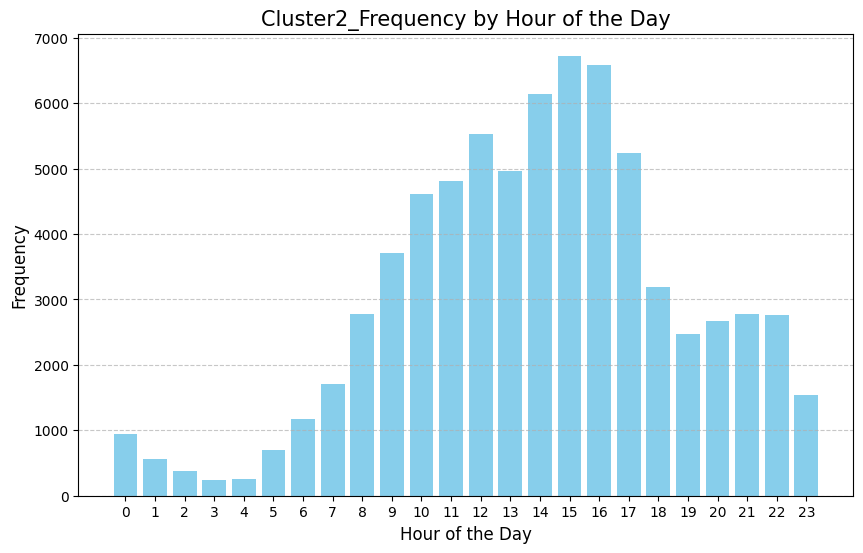

In [ ]:
# 경고 무시 설정
warnings.filterwarnings("ignore")

time_counts = cluster_2['time'].value_counts().sort_index()

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(time_counts.index, time_counts.values, color='skyblue')
plt.title('Cluster2_Frequency by Hour of the Day', fontsize=15)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(time_counts.index)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

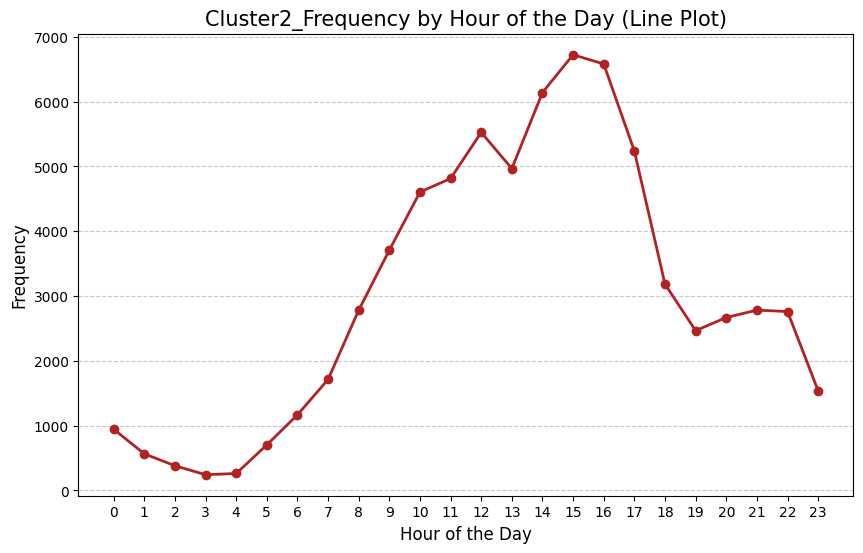

In [ ]:
import matplotlib.pyplot as plt

# 시간대별 빈도수 계산
time_counts = cluster_2['time'].value_counts().sort_index()

# 사진에 있는 색상 (다크 레드 색상으로 설정)
custom_color = '#b22222'  # Dark red

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(time_counts.index, time_counts.values, marker='o', color=custom_color, linestyle='-', linewidth=2)
plt.title('Cluster2_Frequency by Hour of the Day (Line Plot)', fontsize=15)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(time_counts.index)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

- 이벤트 타입 별 빈도수

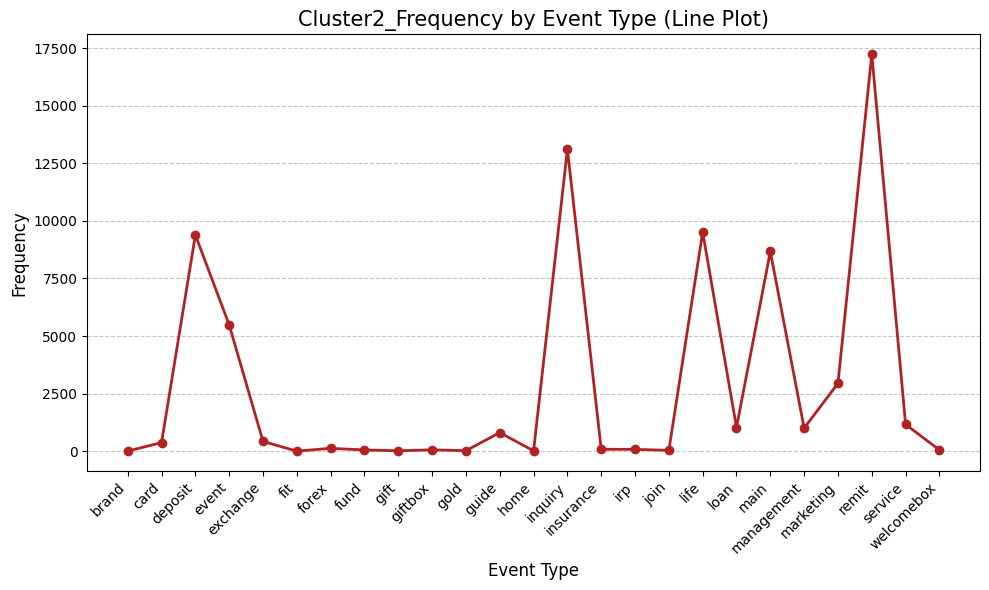

In [ ]:
# 이벤트 타입별 빈도수 계산
event_counts = cluster_2['이벤트타입'].value_counts().sort_index()

# 사진에 있는 색상 (다크 레드 색상으로 설정)
custom_color = '#b22222'  # Dark red

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(event_counts.index, event_counts.values, marker='o', color=custom_color, linestyle='-', linewidth=2)
plt.title('Cluster2_Frequency by Event Type (Line Plot)', fontsize=15)
plt.xlabel('Event Type', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# x축 레이블을 45도 회전하여 겹치지 않게 표시
plt.xticks(event_counts.index, rotation=45, ha='right')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # 그래프가 겹치지 않도록 레이아웃 자동 조정
plt.show()

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not found.

findfont: Font family 'NanumBarunGothic' not f

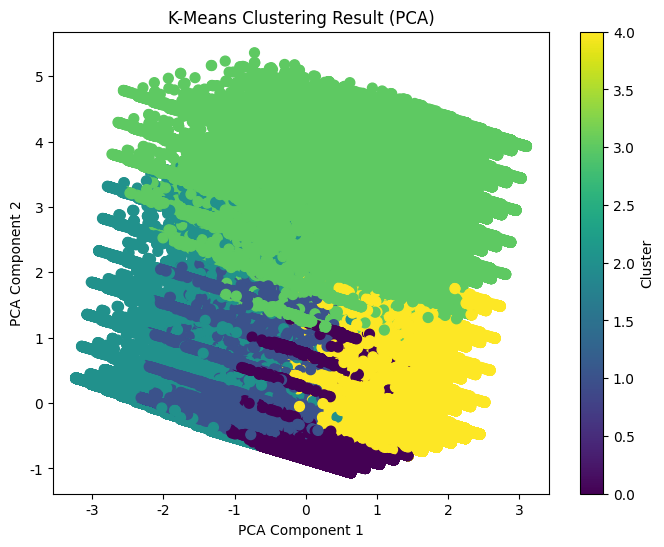

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA

# # PCA를 사용하여 2차원으로 축소
# pca = PCA(n_components=2)
# pca_components = pca.fit_transform(scaled_data)

# # 클러스터링 결과 시각화
# plt.figure(figsize=(8, 6))
# plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df['Cluster'], cmap='viridis', s=50)
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')
# plt.title('K-Means Clustering Result (PCA)')
# plt.colorbar(label='Cluster')
# plt.show()


***여기부터 삭제해도 됨. 심대희가 한 거임***

* 목표: 클러스터링 그룹0을 날짜별로 들어온 customer 수를 확인해보기

NameError: name 'final_cluster_0' is not defined